In [ ]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Loading (remote) E-OBS observations and summer days (SU) calculation

Git repo: https://github.com/rmsryu/spark-climate-data.git
Data set: https://www.ecad.eu/download/ensembles/download.php

E-OBS data is loaded from the remote OpenDAP repository at KNMI. Please, note that when new versions become available the link is no longer valid since the URL is updated with the version number. Therefore, if the code below doesn't work please check the current E-OBS version and update the URL (https://www.ecad.eu/download/ensembles/download.php). 

# Study of daily precipitation from Station Aalsmeer Netherlands
Data source: https://climexp.knmi.nl/data/rrrr458.dat
Data provide by: Royal Netherlands Meteorological Institute (KNMI)

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql.types import *
from pyspark.sql.functions import *



In [114]:
data_files = 'hdfs://hadoop-vm.internal.cloudapp.net:9000/precipitation/data/*/*.parquet'
# Obtain dataset
data = spark.read.parquet(data_files)
data = data.withColumn("precipitation", col("precipitation").cast("float"))
data = data.withColumn("date", col("date").cast("date"))
data.createOrReplaceTempView("climate")
data.cache()

DataFrame[station: string, date: date, precipitation: float]

In [117]:
data.summary().show()

+-------+------------------+-----------------+
|summary|           station|    precipitation|
+-------+------------------+-----------------+
|  count|          13120148|         13120148|
|   mean|483.02698064076714| 2.13989743152896|
| stddev|287.72368836944077|4.339730993138887|
|    min|               001|              0.0|
|    25%|             228.0|              0.0|
|    50%|             466.0|              0.1|
|    75%|             737.0|              2.4|
|    max|               983|            208.0|
+-------+------------------+-----------------+



In [115]:
spark.sql("SELECT station,\
              year(min(date)) min_year, \
              year(max(date)) - year(min(date)) num_years, \
              count(precipitation) count,\
              mean(precipitation) mean, \
              stddev(precipitation) stddev, \
              min(precipitation) min, \
              percentile(precipitation,0.25) 25pct, \
              percentile(precipitation,0.50) 50pct, \
              percentile(precipitation,0.75) 75pct, \
              max(precipitation) max \
            FROM climate GROUP BY station ORDER BY station").show()

+-------+--------+---------+-----+------------------+------------------+---+-----+-------------------+------------------+-----+
|station|min_year|num_years|count|              mean|            stddev|min|25pct|              50pct|             75pct|  max|
+-------+--------+---------+-----+------------------+------------------+---+-----+-------------------+------------------+-----+
|    001|    1940|       83|29556| 2.174519556030149| 4.370148656161713|0.0|  0.0|0.10000000149011612|               2.5| 76.6|
|    003|    1902|       51|18482|2.0838329184571815| 4.277456332945257|0.0|  0.0|0.10000000149011612| 2.299999952316284| 78.4|
|    004|    1904|        1|  419| 1.617899758558996|3.4800441747162214|0.0|  0.0|0.10000000149011612| 1.399999976158142| 26.9|
|    006|    1905|       38|13970|1.7968360776213679| 3.740703703355201|0.0|  0.0|0.10000000149011612| 1.899999976158142| 82.1|
|    007|    1906|       44|15101|1.9131845566100272|3.8756137261021313|0.0|  0.0|                0.0| 2

In [39]:
# take 20 % for visualize
data_plot = data[data.precipitation > 20]

{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-03-30T19:16:35.161+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-03-30T19:16:35.162+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}
{"@version":1,"source_host":"rmsryu-vm","message":"No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.","thread_name":"Thread-4","@timestamp":"2023-03-30T19:16:35.400+0000","level":"WARN","logger_name":"org.apache.spark.sql.execution.window.WindowExec"}


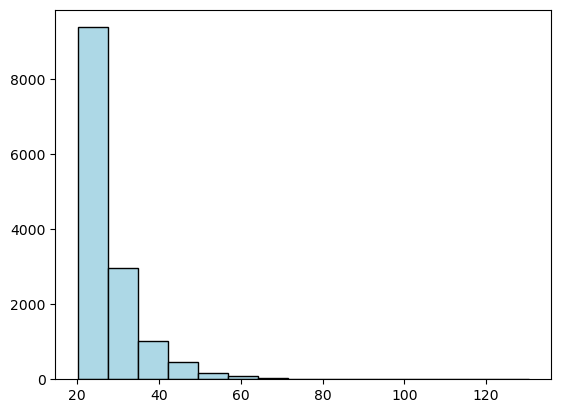

In [40]:
values = data_plot.to_pandas_on_spark().precipitation.tolist()
fig = plt.hist(values, bins=15, color='lightblue', ec = 'black')

In [79]:
station_years_prep = spark.sql("SELECT month(date) month, mean(precipitation) m_prep\
            FROM climate GROUP BY month(date) ORDER BY month(date)")

In [81]:
import calendar

data = station_years_prep.to_pandas_on_spark().to_numpy()
names = list(calendar.month_name)
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

IndexError: tuple index out of range

In [ ]:
import calendar

x = np.arange(list(calendar.month_name))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in station_years_prep.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()